# Machine Learning Models for International Education Costs Prediction
This notebook aims to predict international education costs using various machine learning models. We will use the `International_Education_Costs.csv` dataset.\n
The models to be implemented are:
1. Random Forest Regressor
2. Gradient Boosting Regressor
3. Support Vector Regressor (SVR)
Each model will undergo hyperparameter tuning, and its performance will be evaluated using standard regression metrics. Visualizations will be provided for model insights.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import joblib
import h5py
import io

%matplotlib inline
sns.set_style('whitegrid')

## 1. Load and Inspect Data

In [25]:
try:
    df = pd.read_csv('International_Education_Costs.csv')
    print('Dataset loaded successfully.')
    print('First 5 rows of the dataset:')
    print(df.head())
    print('Dataset Information:')
    df.info()
    print('Descriptive Statistics:')
    print(df.describe())
except FileNotFoundError:
    print('Error: International_Education_Costs.csv not found. Please ensure the file is in the same directory as the notebook.')

Dataset loaded successfully.
First 5 rows of the dataset:
     Country       City                      University  \
0        USA  Cambridge              Harvard University   
1         UK     London         Imperial College London   
2     Canada    Toronto           University of Toronto   
3  Australia  Melbourne         University of Melbourne   
4    Germany     Munich  Technical University of Munich   

                  Program   Level  Duration_Years  Tuition_USD  \
0        Computer Science  Master             2.0        55400   
1            Data Science  Master             1.0        41200   
2      Business Analytics  Master             2.0        38500   
3             Engineering  Master             2.0        42000   
4  Mechanical Engineering  Master             2.0          500   

   Living_Cost_Index  Rent_USD  Visa_Fee_USD  Insurance_USD  Exchange_Rate  
0               83.5      2200           160           1500           1.00  
1               75.8      1800      

## 2. Data Preprocessing\n
**Important:** Review the output from the cell above. You may need to adjust the `target_column`, `categorical_features`, and `numerical_features` lists below based on your dataset's actual column names and types.

In [26]:
target_column = 'Living_Cost_Index'

if target_column not in df.columns and target_column != 'PLEASE_DEFINE_TARGET_COLUMN':
    print(f'Error: Target column \'{target_column}\' not found in DataFrame. Please define it correctly.')
elif target_column == 'PLEASE_DEFINE_TARGET_COLUMN':
    print('Placeholder target column is being used. Please define the actual target column name for the models to work correctly.')
    potential_targets = [col for col in df.select_dtypes(include=np.number).columns if 'cost' in col.lower() or 'fee' in col.lower() or 'price' in col.lower()]
    if potential_targets:
        target_column = potential_targets[0] 
        print(f'Guessed target column: {target_column}. Please verify.')
    elif len(df.select_dtypes(include=np.number).columns) > 0:
        target_column = df.select_dtypes(include=np.number).columns[-1]
        print(f'Fallback target column (last numeric): {target_column}. Please verify.')
    else:
        print('No numeric columns found to use as a fallback target. Preprocessing and modeling will likely fail.')
        df['dummy_target'] = 0 
        target_column = 'dummy_target'

X = df.drop(columns=[target_column, "Visa_Fee_USD", "Insurance_USD"], errors='ignore')
y = df[target_column] if target_column in df.columns else pd.Series(np.zeros(len(df)), name='dummy_target')

categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

print(f'Target column: {target_column}')
print(f'Categorical features: {categorical_features}')
print(f'Numerical features: {numerical_features}')

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ], remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}, y_test shape: {y_test.shape}')

Target column: Living_Cost_Index
Categorical features: ['Country', 'City', 'University', 'Program', 'Level']
Numerical features: ['Duration_Years', 'Tuition_USD', 'Rent_USD', 'Exchange_Rate']
X_train shape: (725, 9), X_test shape: (182, 9)
y_train shape: (725,), y_test shape: (182,)


## 3. Model Training and Evaluation\n
We will now train and evaluate the three models: Random Forest, Gradient Boosting, and SVR.

### 3.1 Random Forest Regressor

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Random Forest Hyperparameters:
{'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 50}
Random Forest Evaluation:
MAE: 1.82
MSE: 6.31
R-squared: 0.96
Best Random Forest Hyperparameters:
{'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 50}
Random Forest Evaluation:
MAE: 1.82
MSE: 6.31
R-squared: 0.96


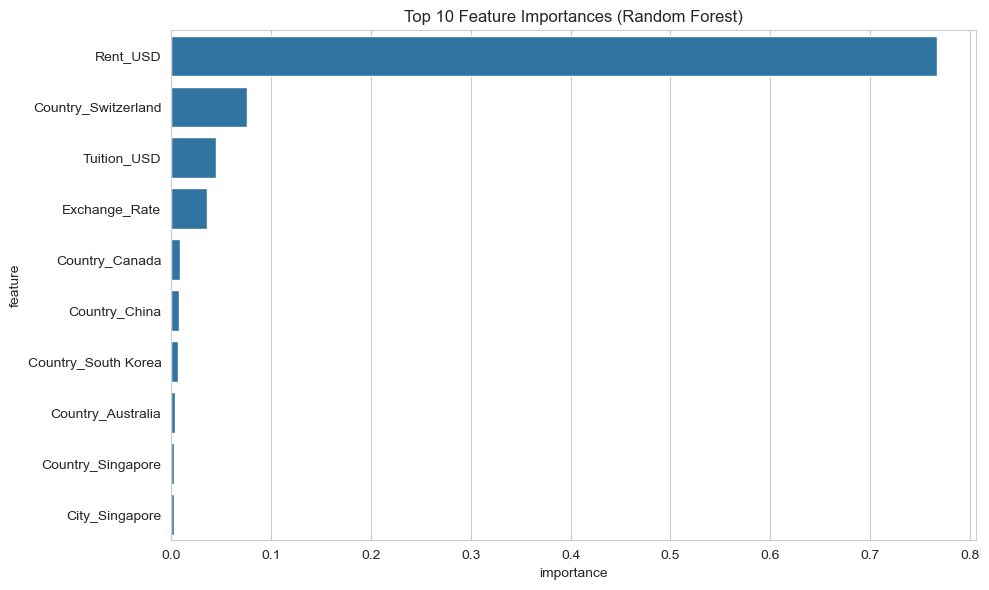

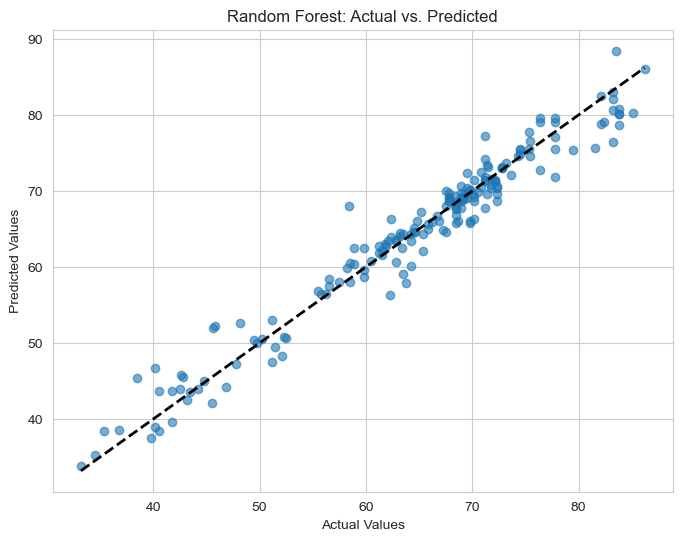

Random Forest model saved to random_forest_model.h5


In [27]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

rf_param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [None, 10],
    'regressor__min_samples_split': [2, 5]
}

rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
try:
    rf_grid_search.fit(X_train, y_train)
    print('Best Random Forest Hyperparameters:')
    print(rf_grid_search.best_params_)
    best_rf_model = rf_grid_search.best_estimator_

    y_pred_rf = best_rf_model.predict(X_test)
    print('Random Forest Evaluation:')
    print(f'MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}')
    print(f'MSE: {mean_squared_error(y_test, y_pred_rf):.2f}')
    print(f'R-squared: {r2_score(y_test, y_pred_rf):.2f}')

    try:
        feature_names = list(best_rf_model.named_steps['preprocessor'].transformers_[0][2]) # Numerical
        ohe_categories = best_rf_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].categories_
        for i, col in enumerate(categorical_features):
            feature_names.extend([f'{col}_{cat_val}' for cat_val in ohe_categories[i]])
        
        importances = best_rf_model.named_steps['regressor'].feature_importances_
        feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).head(10)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=feature_importance_df)
        plt.title('Top 10 Feature Importances (Random Forest)')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f'Could not plot feature importances for Random Forest: {e}')

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_rf, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Diagonal line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Random Forest: Actual vs. Predicted')
    plt.show()

    rf_model_filename = 'random_forest_model.h5'
    try:
        with io.BytesIO() as picklestring_io:
            joblib.dump(best_rf_model, picklestring_io)
            picklestring_io.seek(0)
            with h5py.File(rf_model_filename, 'w') as hf:
                hf.create_dataset('model', data=np.void(picklestring_io.read()))
        print(f'Random Forest model saved to {rf_model_filename}')
    except Exception as e:
        print(f'Error saving Random Forest model: {e}')

except ValueError as e:
    print(f'Error during Random Forest training/evaluation: {e}')
    print('This might be due to issues with the target variable or feature definitions. Please check the preprocessing steps.')
except Exception as e:
    print(f'An unexpected error occurred with Random Forest: {e}')

### 3.2 Gradient Boosting Regressor

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Gradient Boosting Hyperparameters:
{'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 100}
Gradient Boosting Evaluation:
MAE: 1.79
MSE: 5.73
R-squared: 0.96
Best Gradient Boosting Hyperparameters:
{'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 100}
Gradient Boosting Evaluation:
MAE: 1.79
MSE: 5.73
R-squared: 0.96


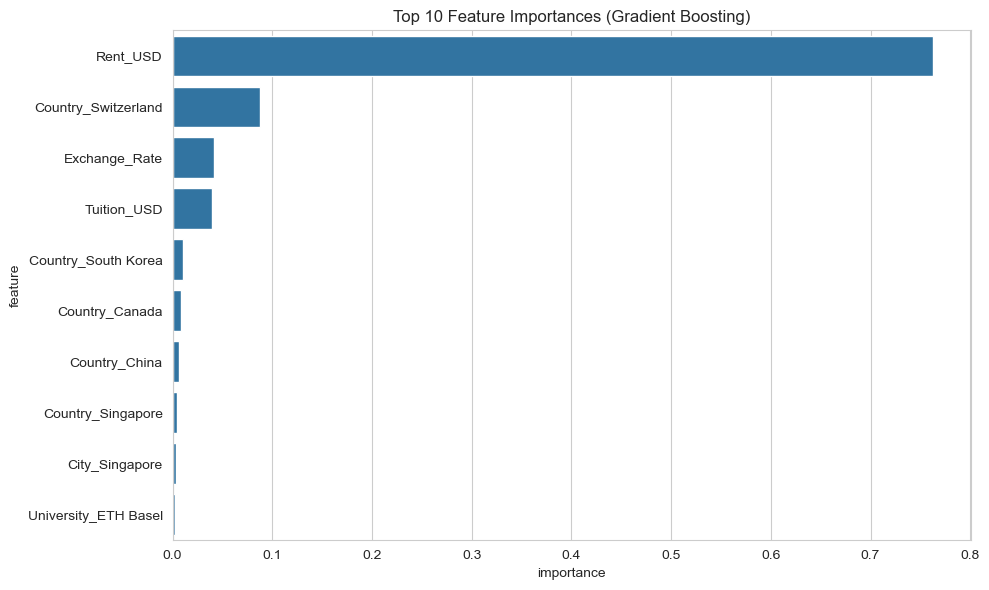

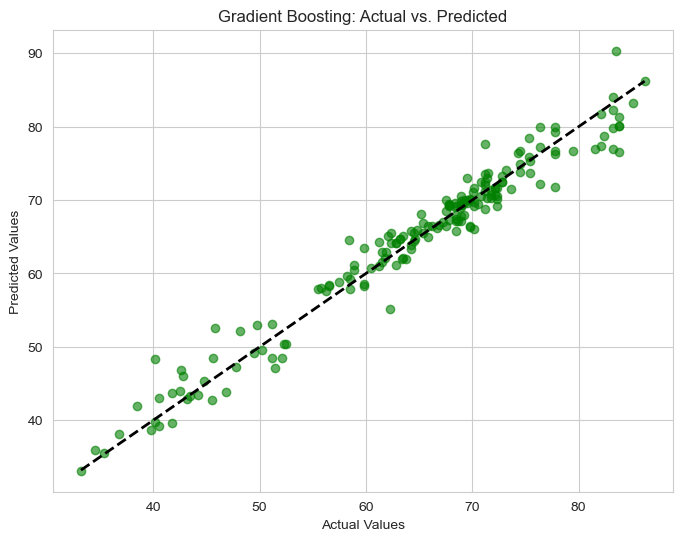

Gradient Boosting model saved to gradient_boosting_model.h5


In [28]:
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

gb_param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5]
}

gb_grid_search = GridSearchCV(gb_pipeline, gb_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
try:
    gb_grid_search.fit(X_train, y_train)
    print('Best Gradient Boosting Hyperparameters:')
    print(gb_grid_search.best_params_)
    best_gb_model = gb_grid_search.best_estimator_

    # Evaluation
    y_pred_gb = best_gb_model.predict(X_test)
    print('Gradient Boosting Evaluation:')
    print(f'MAE: {mean_absolute_error(y_test, y_pred_gb):.2f}')
    print(f'MSE: {mean_squared_error(y_test, y_pred_gb):.2f}')
    print(f'R-squared: {r2_score(y_test, y_pred_gb):.2f}')

    # Feature Importance
    try:
        feature_names = list(best_gb_model.named_steps['preprocessor'].transformers_[0][2]) # Numerical
        ohe_categories = best_gb_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].categories_
        for i, col in enumerate(categorical_features):
            feature_names.extend([f'{col}_{cat_val}' for cat_val in ohe_categories[i]])
            
        importances = best_gb_model.named_steps['regressor'].feature_importances_
        feature_importance_df_gb = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importance_df_gb = feature_importance_df_gb.sort_values(by='importance', ascending=False).head(10)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=feature_importance_df_gb)
        plt.title('Top 10 Feature Importances (Gradient Boosting)')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f'Could not plot feature importances for Gradient Boosting: {e}')

    # Actual vs. Predicted Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_gb, alpha=0.6, color='green')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Diagonal line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Gradient Boosting: Actual vs. Predicted')
    plt.show()

    # Save the model to H5 file
    gb_model_filename = 'gradient_boosting_model.h5'
    try:
        with io.BytesIO() as picklestring_io:
            joblib.dump(best_gb_model, picklestring_io)
            picklestring_io.seek(0)
            with h5py.File(gb_model_filename, 'w') as hf:
                hf.create_dataset('model', data=np.void(picklestring_io.read()))
        print(f'Gradient Boosting model saved to {gb_model_filename}')
    except Exception as e:
        print(f'Error saving Gradient Boosting model: {e}')

except ValueError as e:
    print(f'Error during Gradient Boosting training/evaluation: {e}')
    print('This might be due to issues with the target variable or feature definitions. Please check the preprocessing steps.')
except Exception as e:
    print(f'An unexpected error occurred with Gradient Boosting: {e}')

### 3.3 Support Vector Regressor (SVR)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best SVR Hyperparameters:
{'regressor__C': 10, 'regressor__gamma': 'scale', 'regressor__kernel': 'rbf'}
SVR Evaluation:
MAE: 2.47
MSE: 11.72
R-squared: 0.92


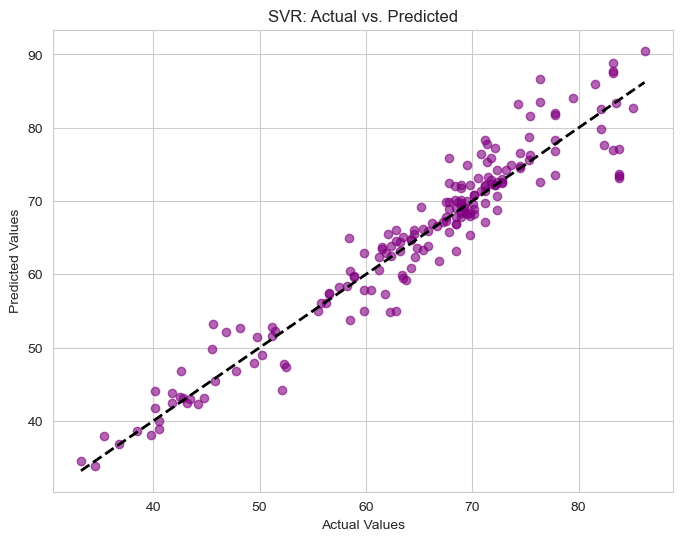

SVR model saved to support_vector_regression_model.h5


In [29]:
svr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])

svr_param_grid = {
    'regressor__C': [0.1, 1, 10],
    'regressor__gamma': ['scale', 'auto'],
    'regressor__kernel': ['rbf']
}

svr_grid_search = GridSearchCV(svr_pipeline, svr_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
try:
    svr_grid_search.fit(X_train, y_train)
    print('Best SVR Hyperparameters:')
    print(svr_grid_search.best_params_)
    best_svr_model = svr_grid_search.best_estimator_

    # Evaluation
    y_pred_svr = best_svr_model.predict(X_test)
    print('SVR Evaluation:')
    print(f'MAE: {mean_absolute_error(y_test, y_pred_svr):.2f}')
    print(f'MSE: {mean_squared_error(y_test, y_pred_svr):.2f}')
    print(f'R-squared: {r2_score(y_test, y_pred_svr):.2f}')

    # Actual vs. Predicted Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_svr, alpha=0.6, color='purple')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Diagonal line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('SVR: Actual vs. Predicted')
    plt.show()

    # Save the model to H5 file
    svr_model_filename = 'support_vector_regression_model.h5'
    try:
        with io.BytesIO() as picklestring_io:
            joblib.dump(best_svr_model, picklestring_io)
            picklestring_io.seek(0)
            with h5py.File(svr_model_filename, 'w') as hf:
                hf.create_dataset('model', data=np.void(picklestring_io.read()))
        print(f'SVR model saved to {svr_model_filename}')
    except Exception as e:
        print(f'Error saving SVR model: {e}')

except ValueError as e:
    print(f'Error during SVR training/evaluation: {e}')
    print('This might be due to issues with the target variable or feature definitions. Please check the preprocessing steps.')
    print('SVR is also sensitive to unscaled target variables if their range is very large.')
except Exception as e:
    print(f'An unexpected error occurred with SVR: {e}')

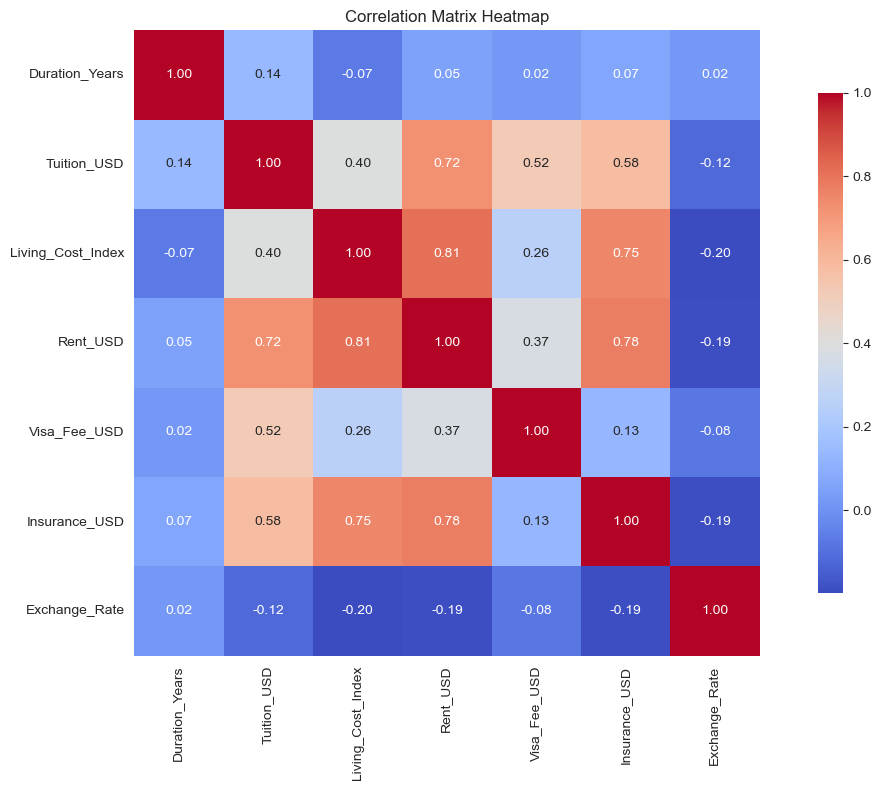

In [30]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
# Select only numerical columns for correlation calculation
numerical_df = df.select_dtypes(include=[np.number])
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

--- Starting Gradient Boosting Model Test Cell ---
Gradient Boosting model loaded successfully from gradient_boosting_model.h5
Using X_train columns for sample data: ['Country', 'City', 'University', 'Program', 'Level', 'Duration_Years', 'Tuition_USD', 'Rent_USD', 'Exchange_Rate']
Numerical features for samples: ['Duration_Years', 'Tuition_USD', 'Rent_USD', 'Exchange_Rate']
Categorical features for samples: ['Country', 'City', 'University', 'Program', 'Level']

Sample input data (auto-filled, PLEASE VERIFY FEATURE NAMES AND VALUES):
   Country      City           University           Program   Level  \
0   Canada   Toronto  Stanford University  Computer Science  Master   
1      USA  New York  Stanford University  Computer Science  Master   
2  Germany    Berlin  Stanford University  Computer Science  Master   

   Duration_Years   Tuition_USD    Rent_USD  Exchange_Rate  
0        2.817931  16603.737931  970.427586     513.666276  
1        2.817931  16603.737931  970.427586     513.66

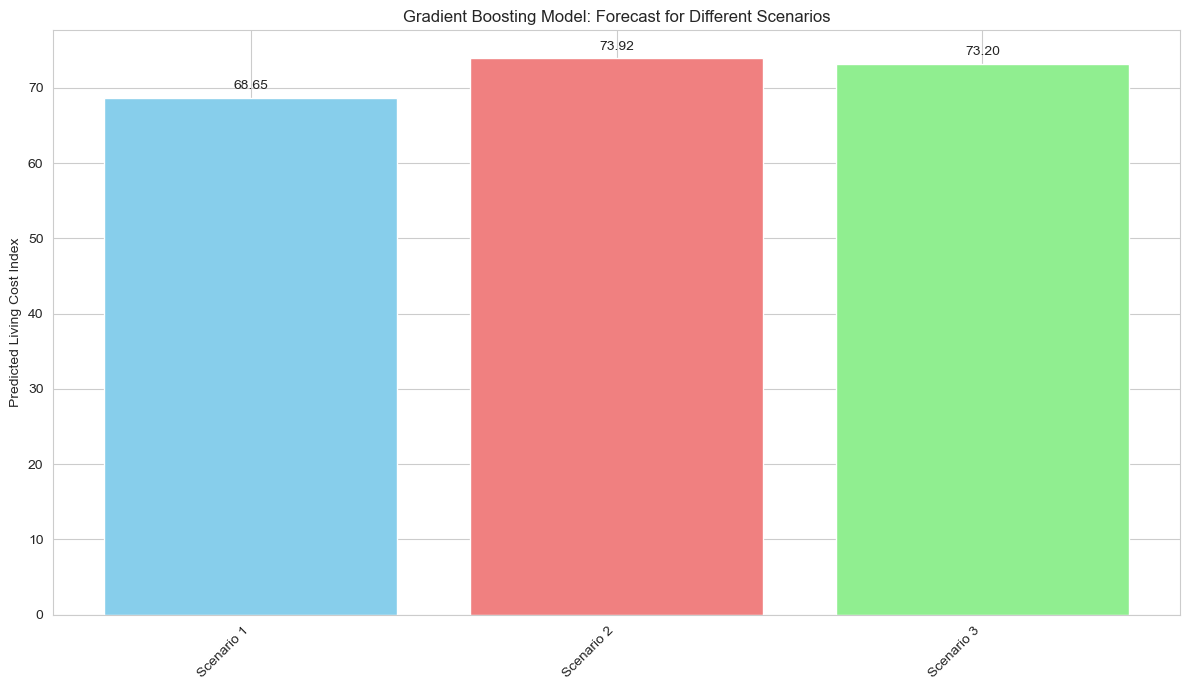


Skipping range test: 'Tuition_Fee_USD' not in identified numerical features for the model.
--- Finished Gradient Boosting Model Test Cell ---


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import h5py
import io

# Ensure previous cells defining df, X_train, numerical_features, categorical_features have been run
# Or reload/redefine them if necessary. For this example, we assume they are in scope.
print("--- Starting Gradient Boosting Model Test Cell ---")

# Load the Gradient Boosting model
gb_model_filename = 'gradient_boosting_model.h5'
loaded_gb_model = None
try:
    with h5py.File(gb_model_filename, 'r') as hf:
        model_bytes = hf['model'][()]
    with io.BytesIO(model_bytes) as picklestring_io:
        loaded_gb_model = joblib.load(picklestring_io)
    print(f"Gradient Boosting model loaded successfully from {gb_model_filename}")
except FileNotFoundError:
    print(f"Error: Model file {gb_model_filename} not found.")
    loaded_gb_model = None
except Exception as e:
    print(f"Error loading Gradient Boosting model: {e}")
    loaded_gb_model = None # Ensure it's None if loading failed

X_train_available = False # Flag to track if X_train and related vars are available
model_input_features = []
numerical_features_model = []
categorical_features_model = []

if loaded_gb_model:
    # Check if necessary variables from previous cells are available
    if 'X_train' not in globals() or 'numerical_features' not in globals() or 'categorical_features' not in globals() or 'df' not in globals() :
        print("Warning: df, X_train, numerical_features, or categorical_features not found in the global scope.")
        print("Attempting to infer feature names from the loaded model's preprocessor.")
        print("Sample data generation will rely on manually specified values or NaN for unspecfied features.")
        try:
            preprocessor_from_model = loaded_gb_model.named_steps['preprocessor']
            
            num_transformer_config = next((t for t in preprocessor_from_model.transformers_ if t[0] == 'num'), None)
            if num_transformer_config:
                numerical_features_model = list(num_transformer_config[2]) 
            else:
                numerical_features_model = []
            
            cat_transformer_config = next((t for t in preprocessor_from_model.transformers_ if t[0] == 'cat'), None)
            if cat_transformer_config:
                categorical_features_model = list(cat_transformer_config[2])
            else:
                categorical_features_model = []

            model_input_features = numerical_features_model + categorical_features_model
            if not model_input_features:
                 print("Error: Could not determine model input features from preprocessor. Cannot create sample data.")
                 loaded_gb_model = None 
            else:
                print(f"Inferred numerical features from model: {numerical_features_model}")
                print(f"Inferred categorical features from model: {categorical_features_model}")
                print(f"Model expects columns: {model_input_features}")
                X_train_available = False # Explicitly set as false
        except Exception as e_features:
            print(f"Error inferring features from model: {e_features}")
            loaded_gb_model = None 
    else: # X_train and other variables are available
        X_train_available = True
        # Use features from the global scope (defined in previous cells)
        numerical_features_model = numerical_features 
        categorical_features_model = categorical_features 
        model_input_features = list(X_train.columns) # These are the features the model was trained on
        print(f"Using X_train columns for sample data: {model_input_features}")
        print(f"Numerical features for samples: {numerical_features_model}")
        print(f"Categorical features for samples: {categorical_features_model}")
            
if loaded_gb_model and model_input_features:
    sample_inputs_list = []
    
    # --- Define Sample Data ---
    # !!! USER ACTION REQUIRED !!!
    # Adjust these feature names and values based on your actual dataset columns.
    # The names 'Tuition_Fee_USD', 'Accommodation_Monthly_Cost_USD', 'Course_Duration_Years', 
    # 'Country', 'City', 'Course_Level' are GUESSES.
    # Check your unique_values.txt or df.describe() for valid categorical values and numerical ranges.

    # Sample 1: Moderate Cost Scenario (e.g., Canada, Bachelors)
    s1 = {}
    # Numerical feature examples (replace with your actual numerical feature names)
    if 'Tuition_Fee_USD' in model_input_features: s1['Tuition_Fee_USD'] = 15000
    if 'Accommodation_Monthly_Cost_USD' in model_input_features: s1['Accommodation_Monthly_Cost_USD'] = 700
    if 'Course_Duration_Years' in model_input_features: s1['Course_Duration_Years'] = 3
    # Categorical feature examples (replace with your actual categorical feature names and ensure values are valid)
    if 'Country' in model_input_features: s1['Country'] = 'Canada' 
    if 'City' in model_input_features: s1['City'] = 'Toronto'    
    if 'Course_Level' in model_input_features: s1['Course_Level'] = 'Bachelors' 
    sample_inputs_list.append(s1)

    # Sample 2: Higher Cost Scenario (e.g., USA, Masters)
    s2 = {}
    if 'Tuition_Fee_USD' in model_input_features: s2['Tuition_Fee_USD'] = 30000
    if 'Accommodation_Monthly_Cost_USD' in model_input_features: s2['Accommodation_Monthly_Cost_USD'] = 1200
    if 'Course_Duration_Years' in model_input_features: s2['Course_Duration_Years'] = 2 
    if 'Country' in model_input_features: s2['Country'] = 'USA'
    if 'City' in model_input_features: s2['City'] = 'New York'
    if 'Course_Level' in model_input_features: s2['Course_Level'] = 'Masters'
    sample_inputs_list.append(s2)
    
    # Sample 3: Lower Cost Scenario (e.g., Germany, Bachelors)
    s3 = {}
    if 'Tuition_Fee_USD' in model_input_features: s3['Tuition_Fee_USD'] = 8000
    if 'Accommodation_Monthly_Cost_USD' in model_input_features: s3['Accommodation_Monthly_Cost_USD'] = 400
    if 'Course_Duration_Years' in model_input_features: s3['Course_Duration_Years'] = 4
    if 'Country' in model_input_features: s3['Country'] = 'Germany'
    if 'City' in model_input_features: s3['City'] = 'Berlin'
    if 'Course_Level' in model_input_features: s3['Course_Level'] = 'Bachelors'
    sample_inputs_list.append(s3)

    filled_sample_inputs = []
    for sample_dict in sample_inputs_list:
        filled_sample = {}
        for col in model_input_features: 
            if col in sample_dict: # Value provided in sample
                filled_sample[col] = sample_dict[col]
            elif X_train_available: # Fill with mean/mode if X_train is available
                if col in numerical_features_model: # Check against numerical_features_model
                    filled_sample[col] = X_train[col].mean()
                elif col in categorical_features_model: # Check against categorical_features_model
                    filled_sample[col] = X_train[col].mode()[0]
                else: # Should not happen if model_input_features is from X_train.columns
                    filled_sample[col] = np.nan 
            else: # X_train not available, fill with NaN (preprocessor should handle)
                filled_sample[col] = np.nan 
        filled_sample_inputs.append(filled_sample)

    sample_df = pd.DataFrame(filled_sample_inputs)
    if not sample_df.empty:
        sample_df = sample_df[model_input_features] # Ensure column order

        print("\nSample input data (auto-filled, PLEASE VERIFY FEATURE NAMES AND VALUES):")
        print(sample_df.head())
        
        predictions = loaded_gb_model.predict(sample_df)
        print("\nPredictions for sample inputs (Living_Cost_Index):")
        print(predictions)

        plt.figure(figsize=(12, 7))
        sample_labels = [f"Scenario {i+1}" for i in range(len(predictions))]
        try:
            bars = plt.bar(sample_labels, predictions, color=['skyblue', 'lightcoral', 'lightgreen'])
            plt.ylabel('Predicted Living Cost Index')
            plt.title('Gradient Boosting Model: Forecast for Different Scenarios')
            plt.xticks(rotation=45, ha="right")
            for bar_idx, bar in enumerate(bars):
                yval = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01 * (predictions.max() if predictions.size > 0 and predictions.max() > 0 else 1) , f'{predictions[bar_idx]:.2f}', ha='center', va='bottom')
            plt.tight_layout()
            plt.show()
        except Exception as e_plot1:
            print(f"Error plotting scenario comparison: {e_plot1}")

        # --- Test with a range of inputs for one feature ---
        # !!! USER ACTION REQUIRED !!!
        # Verify 'Tuition_Fee_USD' is the correct numerical feature you want to vary.
        varied_feature = 'Tuition_Fee_USD' # Change if needed

        if varied_feature in numerical_features_model and X_train_available and varied_feature in X_train.columns:
            feat_min = X_train[varied_feature].min() if not X_train[varied_feature].empty else 1000
            feat_max = X_train[varied_feature].max() if not X_train[varied_feature].empty else 50000
            if feat_min >= feat_max: # Handle cases where min/max are too close or inverted
                feat_min = 1000
                feat_max = 50000
                print(f"Warning: Min/max for {varied_feature} from X_train is problematic. Using default range [{feat_min}-{feat_max}].")

            feature_range_values = np.linspace(feat_min, feat_max, 20)
            
            ranged_inputs_list = []
            base_sample_for_range = filled_sample_inputs[0].copy() if filled_sample_inputs else {}

            if not base_sample_for_range:
                print(f"Base sample for range test is empty, cannot proceed with varying {varied_feature}.")
            else:
                print(f"\nVarying '{varied_feature}' from {feat_min:.2f} to {feat_max:.2f}. Other features based on Scenario 1.")
                for val in feature_range_values:
                    current_sample = base_sample_for_range.copy()
                    current_sample[varied_feature] = val
                    ranged_inputs_list.append(current_sample)
                
                ranged_df = pd.DataFrame(ranged_inputs_list)
                if not ranged_df.empty:
                    ranged_df = ranged_df[model_input_features] 
                    ranged_predictions = loaded_gb_model.predict(ranged_df)

                    plt.figure(figsize=(12, 7))
                    plt.plot(ranged_df[varied_feature], ranged_predictions, marker='o', linestyle='-', color='teal')
                    plt.xlabel(f'{varied_feature} (Varied Input)')
                    plt.ylabel('Predicted Living Cost Index')
                    plt.title(f'Forecast vs. {varied_feature} (Other factors based on Scenario 1)')
                    plt.grid(True)
                    plt.tight_layout()
                    plt.show()
        else:
            if varied_feature not in numerical_features_model:
                 print(f"\nSkipping range test: '{varied_feature}' not in identified numerical features for the model.")
            elif not X_train_available:
                 print(f"\nSkipping range test for '{varied_feature}': X_train data not available for defining range or base sample.")
            elif varied_feature not in X_train.columns : # Should be covered by numerical_features_model check if X_train_available
                 print(f"\nSkipping range test for '{varied_feature}': '{varied_feature}' not in X_train.columns.")
    else:
        print("Sample DataFrame could not be created. Check if model_input_features were correctly identified.")

elif not loaded_gb_model and gb_model_filename == 'gradient_boosting_model.h5':
    print(f"Model file '{gb_model_filename}' was not found or could not be loaded. Cannot proceed with testing.")
elif not model_input_features and loaded_gb_model :
     print("Model loaded, but could not determine its input features. Cannot create sample data for testing.")
elif not loaded_gb_model : 
     print("Model loading failed or model is not available. Cannot proceed with testing.")
else: 
    print("Cannot proceed with testing due to missing model or feature information. Please check previous cell outputs and ensure data is loaded and preprocessed.")

print("--- Finished Gradient Boosting Model Test Cell ---")